In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import numpy as np
from scipy.special import gamma, gammainc
from astropy import units as u
from astropy import constants as const
from scipy.optimize import fsolve

# Conversion from $200m$ to $500c$ overdensity definition

we define a background `astropy` cosmology :

In [2]:
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)

## Define NFW mass profile

First, We need a function $M(<r)$ that provides the mass enclosed in a radius $r$, given a spherical overdensity definition (choice of background density, and $\Delta$). We build a class with such method.

In [3]:
class NFW_profile():
    def __init__(self, M, concentration, z, rho_bgd, delta, cosmo):
        r"""
        Attributes:
        -----------
        M : float
            halo mass
        concentration : float
            halo concentration
        z : float
            halo redshift
        rho_bgd : str
            background density required for the SOD definition (critical, mean)
        delta : float
            overdensity scale (200, 500, etc.)
        cosmo : astropy cosmology
            cosmology object from astropy
        Returns:
        --------
        Compute specific halo quantities (r_delta, r_s) for the mass profile
        """
        self.concentration = concentration
        self.M = M
        if rho_bgd == 'mean': alpha = cosmo.Om(z)
        else : alpha = 1.
        rho_critical = cosmo.critical_density(z).to(u.Msun / u.Mpc**3).value
        self.rdelta = ((M * 3) / (alpha * 4 * np.pi * delta * rho_critical)) ** (1./3.)
        self.rs = self.rdelta / self.concentration

    def delta_c(self, c):
        return np.log(1 + c) - c/(1 + c)
    
    def M_to_r(self,r3d):
        r"""
        Attributes:
        -----------
        r3d : array
            3d radius from the cluster center
        Returns:
        --------
        M_in_r : array
            Mass enclosed in a sphere of radius r
        """
        x = r3d/self.rs
        M_in_r = self.M * self.delta_c(x) / self.delta_c(self.concentration)
        return M_in_r

## Example
### First SOD definition

We define halo parameters following the $200m$ overdensity definition:
1. the mass $M_{200m}$ 
2. the concentration $c_{200m}$

In [4]:
#cluster redshift
z = 0.4
#first SOD definition
M1 = 1e14
c1 = 3
delta1 = 200
background_density1 = 'mean'

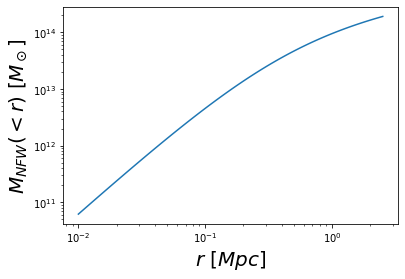

In [5]:
cl1 = NFW_profile(M1, c1, z, background_density1, delta1, cosmo_astropy)
r = np.logspace(-2, 0.4, 100)
plt.loglog(r, cl1.M_to_r(r))
plt.xlabel(r'$r\ [Mpc]$', fontsize = 20)
plt.ylabel(r'$M_{NFW}(<r)\ [M_\odot]$', fontsize = 20)
plt.show()

### Second SOD definition
we choose the second definition (here, we choose 500c)

In [6]:
#2nd mass definition
delta2 = 500
background_density2 = 'critical'

### Conversion between 200m to 500c

To find $M_2$ and $c_2$ following the second SOD definition, we solve the system:
- $M_{M_1, c_1}(r_1) = M_{M_2, c_2}(r_1)$
- $M_{M_1, c_1}(r_2) = M_{M_2, c_2}(r_2)$

where $M_{M_i, c_i}(r)$ is the mass enclosed within a sphere or radius $r$, following a parametrization with overdensity mass $M_i$ and concentration $c_i$. Here, $r_i$ is the overdensity radius $r_{\Delta_i}$ following the overdensity definition $i$, given by
$$
r_{\Delta_i} = \left(\frac{3M_{\Delta_i}}{4\pi \Delta_i \rho_{\rm bckgd,i}}\right)^{1/3}
$$
This leads to 2 equations, knowing that $M_{M_i, c_i}(r_i) = M_{\Delta_i}$
- $M_1 = M_{M_2, c_2}(r_1)$
- $M_{M_1, c_1}(r_2) = M_2$

In [7]:
def M_to_M(M1, c1, delta1, z, rho_bg1, delta2, rho_bg2, cosmo_astropy):
    r"""
    Attributes:
    -----------
    M1: float
        halo mass (1st SOD definition)
    c1: float
        halo concentration (1st SOD definition)
    delta1: float
        Overdensity scale (1st SOD definition)
    rho_bg1: str
        background density (1st SOD definition)
    z: float
        halo redshift
    delta2: float
        Overdensity scale (2nd SOD definition)
    rho_bg2: str
        background density (2nd SOD definition)
    cosmo_astropy: astropy object
        cosmology
    Returns:
    --------
    M2fit, c2fit: float, float
        mass and concentration for the 2nd halo definition
    """
    cl1 = NFW_profile(M1, c1, z, rho_bg1, delta1, cosmo_astropy)
    r1 = cl1.rdelta
    def f(param):
        M2, c2 = param[0], param[1]        
        cl2 = NFW_profile(M2, c2, z, rho_bg2, delta2, cosmo_astropy)
        r2 = cl2.rdelta  
        first_term = M1 - cl2.M_to_r(r1)
        second_term = M2 - cl1.M_to_r(r2)  
        return first_term, second_term
    x0 = [M1, c1]
    M2fit, c2fit = fsolve(func = f, x0 = x0, maxfev = 1000)
    M2fit, c2fit = fsolve(func = f, x0 = [M2fit, c2fit], maxfev = 100)
    return M2fit, c2fit

In [8]:
M2, c2 = M_to_M(M1, c1, delta1, z, background_density1, delta2, background_density2, cosmo_astropy)

In [9]:
print(f'M_2 = {M2:.2e} M_sun')
print(f'c_2 = {c2:.2f}')

M_2 = 4.29e+13 M_sun
c_2 = 1.32


To test the method, we plot the bias between the 2 mass profiles corresponding respectively to the 2 SOD definitions.
    $$
    \frac{M_{M_2, c_2}(<r) - M_{M_1, c_1}(<r)}{M_{M_1, c_1}(<r)}
    $$

In [10]:
#1st SOD definition
input_cl = NFW_profile(M1, c1, z, background_density1, delta1, cosmo_astropy)
#2nd SOD definition
output_cl = NFW_profile(M2, c2, z, background_density2, delta2, cosmo_astropy)

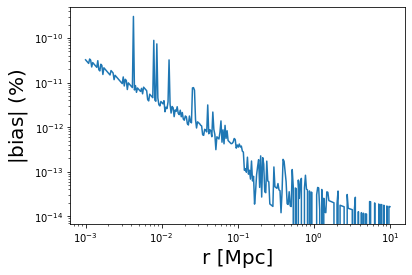

In [11]:
r = np.logspace(-3,1,300)
plt.loglog(r, 100*abs((output_cl.M_to_r(r)-input_cl.M_to_r(r))/input_cl.M_to_r(r)))
plt.xlabel('r [Mpc]', fontsize = 20)
plt.ylabel(r'|bias| ($\%$)', fontsize = 20)
plt.show()